In [ ]:
!pip install finance-datareader
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 런타임 다시 시작 (Ctrl + M)ㅡ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.5 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,184 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend

In [ ]:
# 필요 모듈 import / matplotlib 글꼴 설정
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import random
import math
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

plt.rc('font', family='NanumBarunGothic')
stockList = fdr.StockListing('KRX')

In [ ]:
def crawl(page,kospi100):  # Crawling 하는 함수
  res = requests.get("https://finance.naver.com/sise/sise_market_sum.naver?&page="+str(page))
  soup = BeautifulSoup(res.content, 'html.parser')
  company = soup.select('tbody > tr > td:nth-of-type(2) > a')
  for i in range(len(company)):
    name = company[i].contents[0]
    if ~(stockList[stockList['Name']==name]['Sector']).isnull().values.any():   # 우선주, ETF 제거
      if (stockList[stockList['Name']==name]['ListingDate']<'2017-7-1').item():       # 2017-7이전에 상장한 종목만 선택
        code = company[i].attrs['href'][-6:]                    # 종목코드 추출
        kospi100[code] = name
        if len(kospi100)==100:
          break
  return kospi100

def getKOSPI100(): # 100개 추출하는 함수
  page = 1
  kospi100 = dict()
  while(len(kospi100)!=100):
    kospi100 = crawl(page,kospi100)
    page+=1
  return kospi100

def getMA(stockData):  # Moving Average 계산
  stockData['5MA']=stockData['Close'].rolling(5).mean()
  stockData['20MA']=stockData['Close'].rolling(20).mean()
  stockData['60MA']=stockData['Close'].rolling(60).mean()
  stockData['120MA']=stockData['Close'].rolling(120).mean()

  # 지표 가공
  stockData['MA5_20'] = np.where(stockData['5MA']>stockData['20MA'],1.0,0.0)
  stockData['MA5_60'] = np.where(stockData['5MA']>stockData['60MA'],1.0,0.0)
  stockData['MA5_120'] = np.where(stockData['5MA']>stockData['120MA'],1.0,0.0)
  stockData['5_20positions'] = stockData['MA5_20'].diff()
  stockData['5_60positions'] = stockData['MA5_60'].diff()
  stockData['5_120positions'] = stockData['MA5_120'].diff()
  return stockData

def getMACD(stockData, short= 12, long= 26, signal=9):
  stockData['ema_short'] = stockData['Close'].ewm(short).mean()  # exponential weighted average
  stockData['ema_long'] = stockData['Close'].ewm(long).mean()
  stockData['MACD'] = stockData['ema_short'] - stockData['ema_long']  #단기 지수이평선 - 장기 지수이평선
  stockData['MACD_Signal'] = stockData['MACD'].ewm(signal).mean() # MACD의 9일 이동평균선을 구함

  # 지표 가공
  # 골든크로스시 매입 데드크로스시 매도
  # 0을 상승 돌파 하면 매입 하향 돌파 하면 매도
  stockData['MACD_MACDSignal'] = np.where(stockData['MACD']>stockData['MACD_Signal'],1.0,0.0)
  stockData['MACDpositions'] = stockData['MACD_MACDSignal'].diff()  # MACD와 MACD Signal간의 골든크로스 여부 확인
  return stockData

def UD(diff):
  ups = 0
  downs = 0
  if diff > 0:
    ups = diff
  elif diff <0:
    downs = abs(diff)
  return pd.Series([ups,downs])

def getRSI(stockData, days=14, signal=6):
  stockData["diff"] = stockData["Close"].diff()
  stockData[["U","D"]] = stockData["diff"].apply(UD) # difference를 구해 상승하면 U, 떨어지면 D
  stockData["AU"] = stockData["U"].rolling(days).mean() #U에 대한 14일 평균값
  stockData["AD"] = stockData["D"].rolling(days).mean() #D에 대한 14일 평균값
  stockData["RS"] = stockData["AU"]/stockData["AD"] # AU/AD가 RS(Relative strength)로 RS가 큰 것은 상승 폭이 더 크다는 것을 의미
  stockData["RSI"] = stockData["RS"]/(1+stockData["RS"]) # 백분율값을 구함 AU/(AU+AD)
  stockData["RSI_Signal"] = stockData["RSI"].rolling(signal).mean() # RSI의 6일 이동평균선

  stockData['RSI_RSISignal'] = np.where(stockData['RSI']>stockData['RSI_Signal'],1.0,0.0)
  stockData['RSI_cross'] = stockData['RSI_RSISignal'].diff()  # RSI와 RSI Signal간의 골든크로스 여부 확인
  return stockData


# MACD Golden/ Dead 이용해서 매매 signal 받기
# RSI 지표상 70이상이면 매수 중지,,30이하면 매도 중지..
# 기본적인 MA를 기본으로 하되 MACD 지표와 RSI지표에서 Signal이 나오는 경우 MACD RSI 지표를 우선으로 함...
# 떨어질 때 어떻게 처리할 것인지가 필요!!

def preprocessData(code, sDay, eDay=None):
  rsDay = datetime.strptime(sDay, "%Y")
  rsDay = rsDay - timedelta(days=180)
  stockData = fdr.DataReader(code,rsDay,eDay)
  stockData.drop(['Open','High','Low'], axis=1, inplace=True)
  stockData = getMA(stockData)
  stockData.drop(['MA5_20','MA5_60','MA5_120'], axis=1, inplace=True)
  stockData = getRSI(stockData)
  stockData.drop(['U','D','AU','AD','RS'], axis=1, inplace=True)
  stockData = getMACD(stockData)
  stockData.drop(['ema_short','ema_long','MACD_MACDSignal'], axis=1, inplace=True)
  stockData = stockData[sDay:]
  return stockData

In [ ]:
def makeSignalWithMA(data, name, bWeight_20=0.3, sWeight_20=0.5, bWeight_60=0.2, sWeight_60=0.7, bWeight_120=0.1, sWeight_120=0.9 ):
  positions = pd.DataFrame()
  positions['5_20Signal'] = data['5_20positions'].apply(lambda x : x*bWeight_20 if(x>=0) else x*sWeight_20)
  positions['5_60Signal'] = data['5_60positions'].apply(lambda x : x*bWeight_60 if(x>=0) else x*sWeight_60)
  positions['5_120Signal'] = data['5_120positions'].apply(lambda x : x*bWeight_120 if(x>=0) else x*sWeight_120)

  positions = positions.replace(0, np.NaN)
  positions['MAPosition'] = positions[['5_20Signal','5_60Signal','5_120Signal']].bfill(axis=1).iloc[:, 0]   # Signal은 5_20 >  5_60  > 5_120을 우선시함.
  positions = positions.replace(np.NaN, 0.0)
  data['MAPosition'] = positions['MAPosition']
  data.drop(['5_20positions','5_60positions','5_120positions'], axis=1, inplace=True)
  return data

def makeSignalWithMACD(data, name, bWeight_zero=0.3, sWeight_zero= 0.5, bWeight_cross=0.2, sWeight_cross=0.2):
  positions = pd.DataFrame()
  positions['MACD_crossSignal'] = data['MACDpositions'].apply(lambda x : x*bWeight_cross if(x>=0) else x*sWeight_cross)

  data['MACDbreak'] = (data['MACD'] * (data['MACD'].shift(1))).apply(lambda x : 1.0 if( x<0 ) else 0.0)  # 이전 곱과 지금 곱을 통하여 0을 상승 혹은 하강 돌파했는지 확인.
  positions['MACDuppoint'] = (data['MACD']*data['MACDbreak']).apply(lambda x : bWeight_zero if(x>0) else 0.0) # 곱이 음수이고 현재의 MACD가 음수라면 하향돌파를 한 것임
  positions['MACDdownpoint'] = (data['MACD']*data['MACDbreak']).apply(lambda x : sWeight_zero if(x<0) else 0.0) # 곱이 음수이고 현재의 MACD가 양수이면 상향돌파를 한 것임.

  positions = positions.replace(0, np.NaN)
  positions['MACDPosition'] = positions[['MACDuppoint','MACDdownpoint','MACD_crossSignal']].bfill(axis=1).iloc[:, 0]   # Signal은 0돌파 >  크로스을 우선시함.
  positions = positions.replace(np.NaN, 0.0)
  data['MACDPosition'] = positions['MACDPosition']
  data.drop(['MACDpositions','MACDbreak'], axis=1, inplace=True)
  return data

def makeSignalWithRSI(data, name, high=0.7, low=0.3, bWeight_cross=0.4, sWeight_cross= 0.9):
  positions = pd.DataFrame()
  positions['RSI_crossSignal'] = data['RSI_cross'].apply(lambda x : x*bWeight_cross if(x>=0) else x*sWeight_cross)
  positions['RSI_positive'] = positions['RSI_crossSignal'].apply(lambda x : 1 if(x>0) else 0)
  positions['RSI_negative'] = positions['RSI_crossSignal'].apply(lambda x : 1 if(x<0) else 0)

  positions['RSI_70'] = np.where(data['RSI']>= high ,1.0,0.0)
  positions['RSI_30'] = np.where(data['RSI']<= low ,1.0,0.0)

  positions['RSI_sellSignal'] = positions['RSI_crossSignal']*positions['RSI_negative']
  positions['RSI_buySignal'] = positions['RSI_crossSignal']*positions['RSI_positive']
  positions = positions.replace(0, np.NaN)
  positions['RSIPosition'] = positions[['RSI_sellSignal','RSI_buySignal']].bfill(axis=1).iloc[:,0]
  positions = positions.replace(np.NaN, 0.0)
  data['RSIPosition'] = positions['RSIPosition']

  data['Ban_buy'] =  positions['RSI_70']
  data['Ban_sell'] = positions['RSI_30']

  data.drop(['RSI_RSISignal','RSI_cross'], axis=1, inplace=True)

  return data

def makeFinalSignal(data,name):

  # 최우선 순위는 Ban_Buy/ Ban_sell
  # 제약이 없다면 MA/MACD/RSI의 다수결에 따르며 1:1이 나오는 경우 해당 결정은 hold!!
  positions = data[['MAPosition','MACDPosition','RSIPosition','Ban_buy','Ban_sell']]
  resultList=list()
  for i in range(0,len(data)):
      plus = 0
      minus = 0
      maxplus = 0
      maxminus = 0
      stockSignal = -1

      tmp=[data['MAPosition'].iloc[i],data['MACDPosition'].iloc[i],data['RSIPosition'].iloc[i],data['Ban_buy'].iloc[i],data['Ban_sell'].iloc[i]]
      for i in range(3):
        if tmp[i]>0:
          plus += 1
          if maxplus < tmp[i]:
            maxplus = tmp[i]
        elif tmp[i]<0:
          minus += 1
          if maxminus > tmp[i]:
            maxminus = tmp[i]
      if(plus>minus):
        stockSignal=0
        if(tmp[3]!=1.0):
          resultList.append(maxplus)
        else:
          resultList.append(0)
      elif(plus==minus):
        resultList.append(0)
      else:
        if(tmp[4]!=1 & stockSignal!=-1):
          resultList.append(maxminus)
        else:
          resultList.append(0)
  data['FinalSignal'] = resultList

  return data


def gettradeSignal(data, name):
    data = makeSignalWithMA(data, name)
    data = makeSignalWithMACD(data, name)
    data = makeSignalWithRSI(data,name)
    data = makeFinalSignal(data,name)
    return data


In [ ]:
def trade(data,name,seedMoney=float(1000000000)):
  data = gettradeSignal(data,name)

  data['cash'] = np.zeros(len(data))
  data['stocks'] = np.zeros(len(data))
  data['Total'] = np.zeros(len(data))
  data['Total'].iloc[0] = seedMoney

  if(data['FinalSignal'].iloc[0]>0):   # 첫날을 이용한 초기화..
    cashByRatio = seedMoney*data['FinalSignal'].iloc[0]  # 사용할 비용!!
    stocksToBuy = cashByRatio / data['Close'].iloc[0]    #  몇 개를 살 수 있는지 확인..
    leftCash = seedMoney - stocksToBuy * data['Close'].iloc[0] # 남은 돈을 계산함.
    data['cash'].iloc[0] = leftCash
    data['stocks'].iloc[0] = stocksToBuy
  else:
    data['cash'].iloc[0] = seedMoney

  for i in range(1,len(data)):
    stockByRatio = 0
    stocksToBuy = 0
    leftStock = 0
    cashByRatio = 0
    leftCash = 0
    returnCash = 0

    if(data['stocks'].iloc[i-1] == 0):  # 현재 가지고 있는 주식이 없는 경우
      if(data['FinalSignal'].iloc[i] > 0):  # position이 0이상으로 사야하는시기
          cashByRatio = math.floor(data['cash'].iloc[i-1]*data['FinalSignal'].iloc[i])  # 얼마치 구입할지 결정
          stocksToBuy = math.floor(cashByRatio / data['Close'].iloc[i])    #  몇 개를 살 수 있는지 확인..
          leftCash = data['cash'].iloc[i-1] - stocksToBuy * data['Close'].iloc[i] # 남은 돈을 계산함.
      elif(data['FinalSignal'].iloc[i]<0):
        data['FinalSignal'].iloc[i] = 0.0
        leftCash = data['cash'].iloc[i-1]
      else:
        leftCash = data['cash'].iloc[i-1]
      data['cash'].iloc[i] = leftCash
      data['stocks'].iloc[i] = data['stocks'].iloc[i-1] + stocksToBuy
      data['Total'].iloc[i] = data['cash'].iloc[i] + data['stocks'].iloc[i] * data['Close'].iloc[i]
    else:
      if(data['FinalSignal'].iloc[i] > 0): # 매수 포지션인 경우
          cashByRatio = math.floor(data['cash'].iloc[i-1]*data['FinalSignal'].iloc[i])  # 얼마치 구입할지 결정
          stocksToBuy = math.floor(cashByRatio / data['Close'].iloc[i])    #  몇 개를 살 수 있는지 확인..
          leftCash = data['cash'].iloc[i-1] - stocksToBuy * data['Close'].iloc[i] # 남은 돈을 계산함.
          data['cash'].iloc[i] = leftCash
          data['stocks'].iloc[i] = data['stocks'].iloc[i-1] + stocksToBuy
          data['Total'].iloc[i] = leftCash + data['stocks'].iloc[i] * data['Close'].iloc[i]
      elif(data['FinalSignal'].iloc[i] == 0):
          leftCash = data['cash'].iloc[i-1]
          data['cash'].iloc[i] = leftCash
          data['stocks'].iloc[i] = data['stocks'].iloc[i-1]
          data['Total'].iloc[i] = leftCash + data['stocks'].iloc[i] * data['Close'].iloc[i]
      else:
        if(data['stocks'].iloc[i-1]<=10):
          returnCash = data['stocks'].iloc[i-1]* data['Close'].iloc[i]
        else:
          stockByRatio = math.floor(data['stocks'].iloc[i-1] * data['FinalSignal'].iloc[i] * (-1))
          returnCash = stockByRatio * data['Close'].iloc[i]
          leftStock = data['stocks'].iloc[i-1] - stockByRatio
        data['cash'].iloc[i] = data['cash'].iloc[i-1] + returnCash
        data['stocks'].iloc[i] = leftStock
        data['Total'].iloc[i] = data['cash'].iloc[i] + data['stocks'].iloc[i] * data['Close'].iloc[i]

  return data

def visualize(data, name, timeInfo, bWeight_20=0.3, sWeight_20=0.5, bWeight_60=0.2, sWeight_60=0.9, bWeight_120=0.1, sWeight_120=1):

  data[['Close']].plot(figsize=(15,7), title="{share}'s Price Graph({time})".format(share=name, time=timeInfo))

  ax1 = data[["Close","5MA","20MA","60MA","120MA"]].plot(figsize=(15,7), title = "{share}'s Moving Average Graph({time})".format(share=name, time=timeInfo))
  ax1.plot(data['Close'].loc[data['FinalSignal']>0].index, data["Close"][data['FinalSignal']>0],"^",markerfacecolor='red',markersize=10)
  ax1.plot(data['Close'].loc[data['FinalSignal']<0].index, data["Close"][data['FinalSignal']<0],"v",markerfacecolor='blue',markersize=10)

  ax2 = data[["MACD","MACD_Signal"]].plot(figsize=(15,7), title = "{share}'s MACD Graph({time})".format(share=name, time=timeInfo))
  plt.axhline(0.0,c="k", ls="--")

  ax3 = data[["RSI","RSI_Signal"]].plot(figsize=(15,7), title = "{share}'s RSI Graph({time})".format(share=name, time=timeInfo))
  plt.axhline(0.7,c="r", ls="--")  # 0.7 과매수
  plt.axhline(0.5,c="k", ls="--")  # 0.5 평균치
  plt.axhline(0.3,c="b", ls="--")  # 0.3 과매도

  data[['Total']].plot(figsize=(15,7), title="{share}'s Cumsum yield Graph({time})".format(share=name, time=timeInfo))

In [ ]:
def tradeRandomShare():
  code = random.choice(list(kospi100.keys()))

  beforeCorona = preprocessData(code,'2018','2020')
  beforeCorona = trade(beforeCorona,kospi100[code])
  visualize(beforeCorona, kospi100[code],"BeforeCorona")
  beforeCorona[['cash']].plot(figsize=(15,7))
  beforeCorona[['stocks']].plot(figsize=(15,7))

  postCorona = preprocessData(code,'2020')
  postCorona = trade(postCorona,kospi100[code])
  visualize(postCorona, kospi100[code],"PostCorona")
  postCorona[['cash']].plot(figsize=(15,7))
  postCorona[['stocks']].plot(figsize=(15,7))

def makeStatistics(kospi100, yieldDf, time):
  maxYield = -100
  maxStock = "none"
  minYield = 100
  minStock = "none"
  totalRevenue = 0
  plusStocks = 0
  minusStocks = 0

  i=0
  post_yield = []

  for code in kospi100:
    if (time=='before'):
      data = preprocessData(code,'2018','2020')
      result = trade(data,kospi100[code])
      finalYield = (result['Total'][-1]/1000000000-1)*100
      yieldDf.loc[i] = [kospi100[code],finalYield]
    else:
      data = preprocessData(code,'2020')
      result = trade(data,kospi100[code])
      finalYield = (result['Total'][-1]/1000000000-1)*100
      post_yield.append(finalYield)
    i+=1
    if (finalYield>0):
      plusStocks +=1
    else:
      minusStocks +=1

    if finalYield> maxYield:
      maxYield = finalYield
      maxStock = kospi100[code]
    if finalYield< minYield:
      minYield = finalYield
      minStock = kospi100[code]
    totalRevenue += result['Total'][-1]
    print("%s: %d/100" %(time,i))
    visualize(data,kospi100[code],time)

  print("%s: %s  ,   %s: %s" %(maxYield,maxStock,minYield,minStock))
  print("mean: %s" %(totalRevenue/((float(1000000000)*len(kospi100)-1)*100)))
  print("plusStocks: %s, minusStocks: %s" %(plusStocks,minusStocks))

  if(time=='before'):
    return yieldDf
  else:
    return post_yield

def backTesting(kospi100):

  yieldDf = pd.DataFrame(columns=['Company','Before_Yield'])
  yieldDf = makeStatistics(kospi100, yieldDf,'before')
  post_yield =makeStatistics(kospi100, yieldDf,'post')
  yieldDf['Post_Yield'] = post_yield
  drawBarChart(yieldDf)
  return yieldDf

def drawBarChart(yieldResult):
  yieldResult.plot(kind='bar',xlabel=yieldResult['Company'],rot=90, figsize=(15,8))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current f

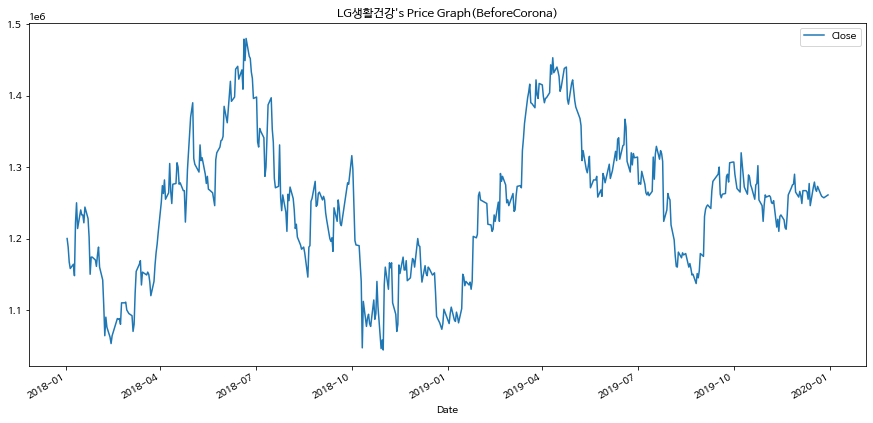

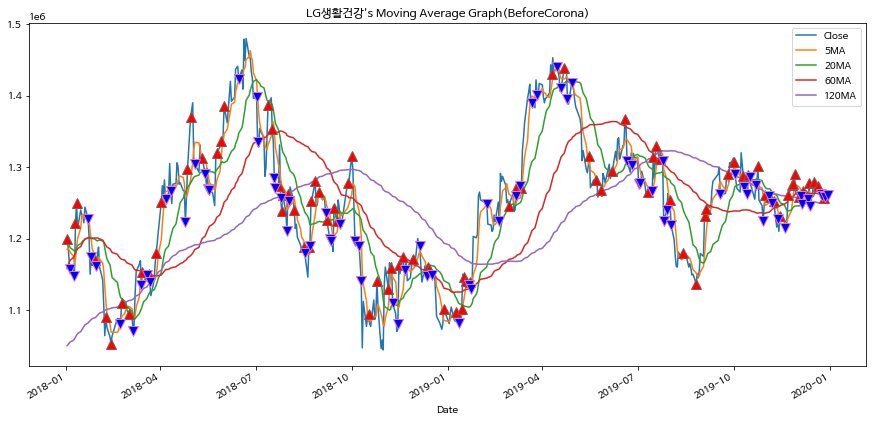

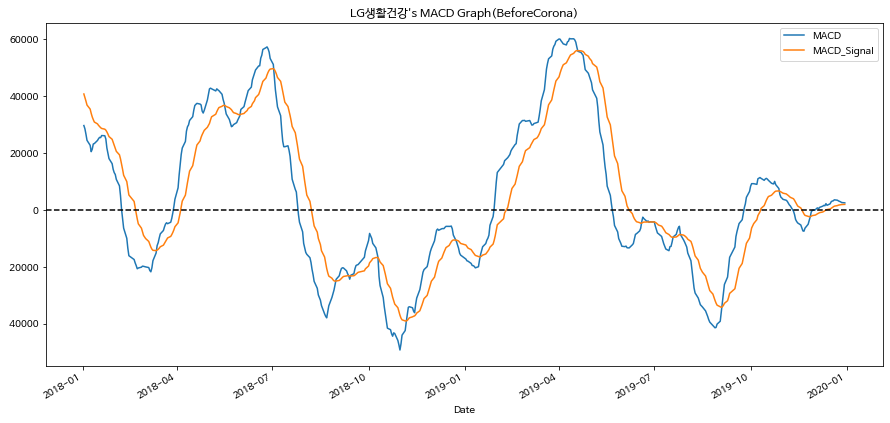

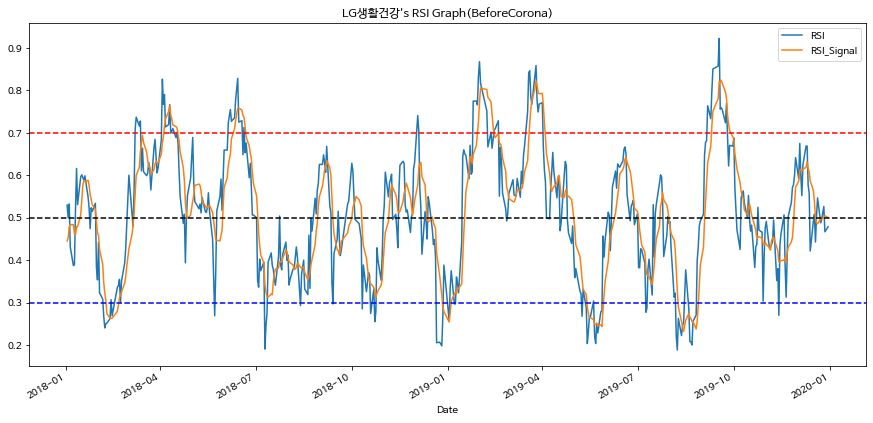

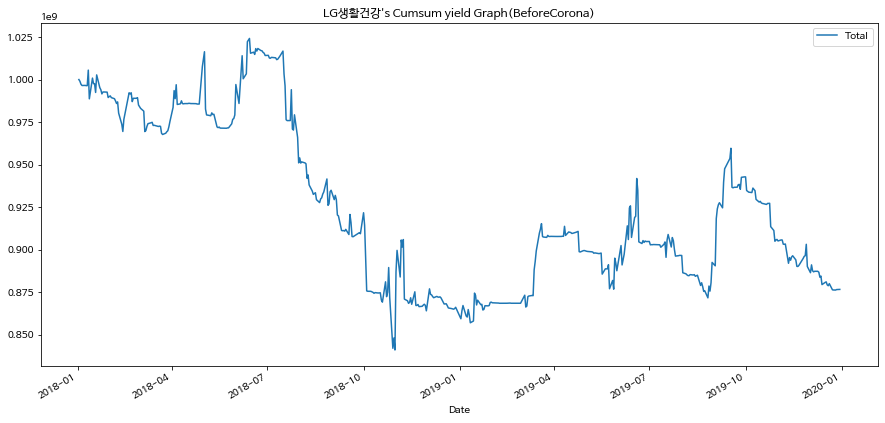

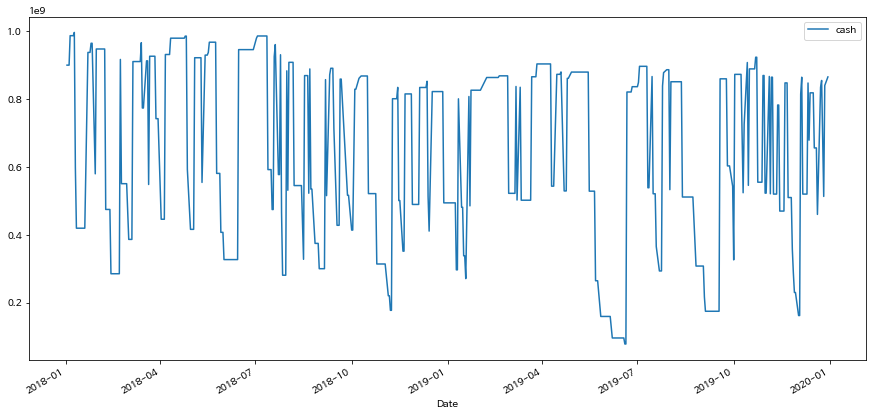

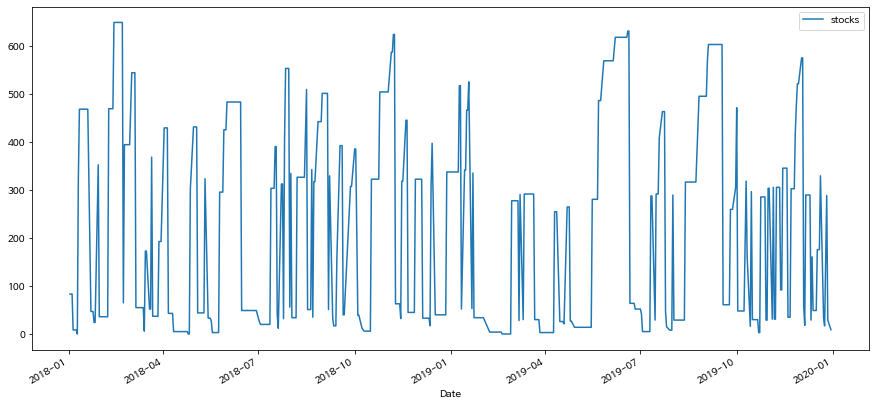

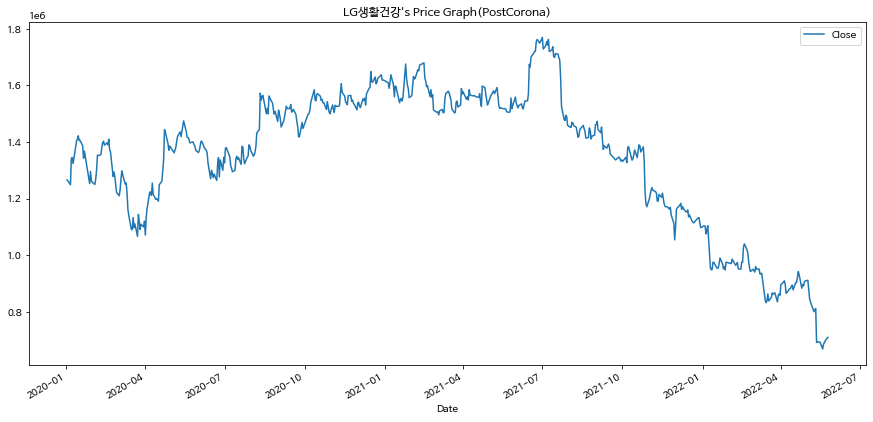

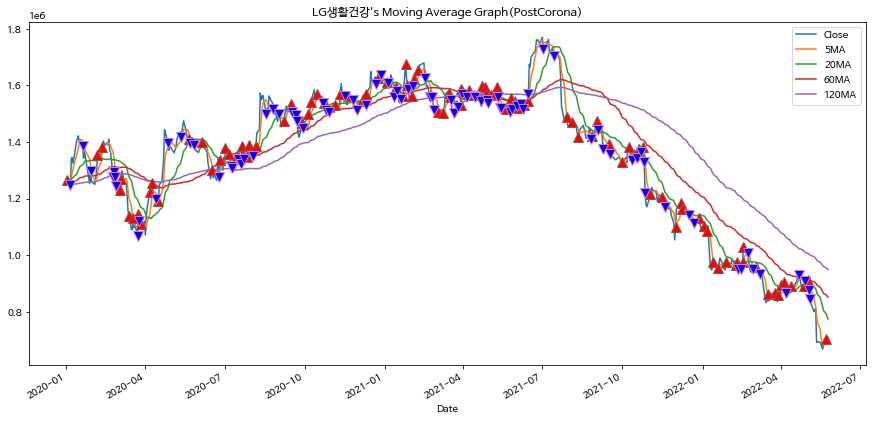

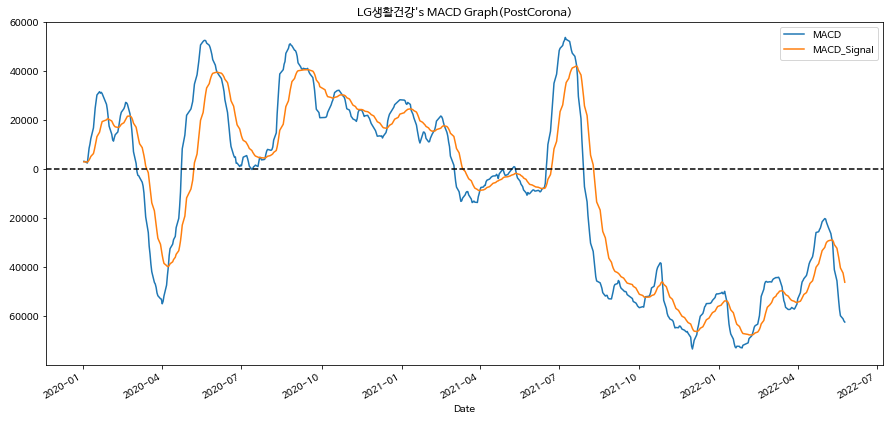

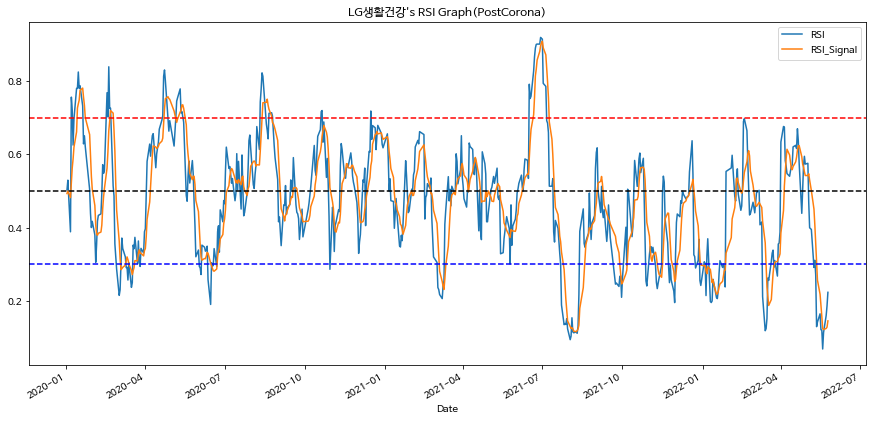

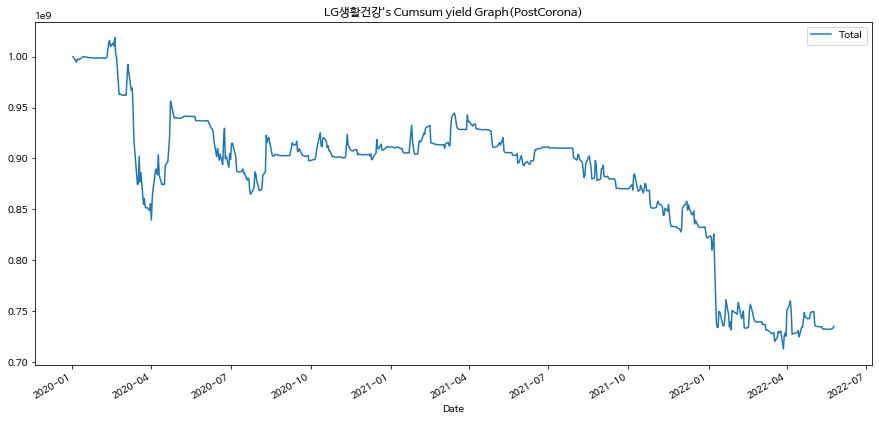

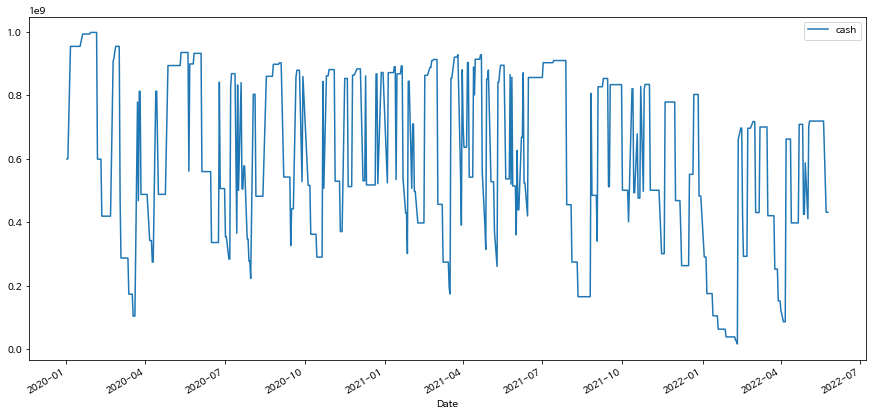

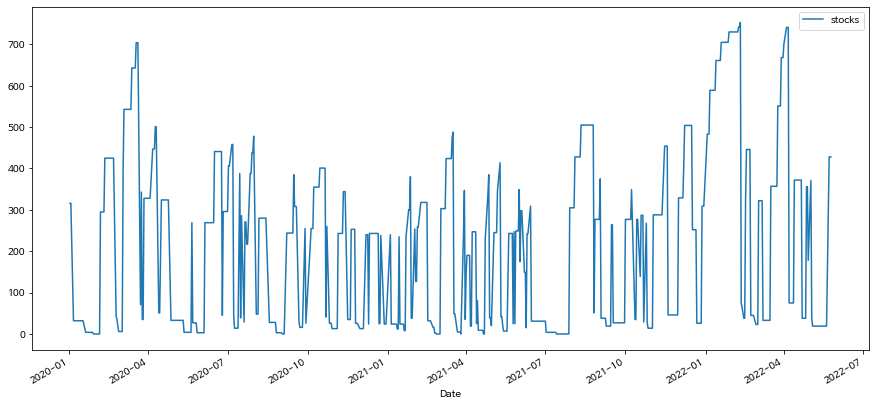

In [ ]:
tradeRandomShare()

In [ ]:
kospi100 = getKOSPI100()

In [ ]:
result = backTesting(kospi100)
result

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


before: 1/100
before: 2/100
before: 3/100
before: 4/100
before: 5/100
before: 6/100
before: 7/100
before: 8/100
before: 9/100
before: 10/100
before: 11/100
before: 12/100
before: 13/100
before: 14/100
before: 15/100
before: 16/100
before: 17/100
before: 18/100
before: 19/100
before: 20/100
before: 21/100
before: 22/100
before: 23/100
before: 24/100
before: 25/100
before: 26/100
before: 27/100
before: 28/100
before: 29/100
before: 30/100
before: 31/100
before: 32/100
before: 33/100
before: 34/100
before: 35/100
before: 36/100
before: 37/100
before: 38/100
before: 39/100
before: 40/100
before: 41/100
before: 42/100
before: 43/100
before: 44/100
before: 45/100
before: 46/100
before: 47/100
before: 48/100
before: 49/100
before: 50/100
before: 51/100
before: 52/100
before: 53/100
before: 54/100
before: 55/100
before: 56/100
before: 57/100
before: 58/100
before: 59/100
before: 60/100
before: 61/100
before: 62/100


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


before: 63/100
before: 64/100
before: 65/100
before: 66/100
before: 67/100
before: 68/100
before: 69/100
before: 70/100
before: 71/100
before: 72/100
before: 73/100
before: 74/100
before: 75/100
before: 76/100
before: 77/100
before: 78/100
before: 79/100
before: 80/100
before: 81/100
before: 82/100
before: 83/100
before: 84/100
before: 85/100
before: 86/100
before: 87/100
before: 88/100
before: 89/100
before: 90/100
before: 91/100
before: 92/100
before: 93/100
before: 94/100
before: 95/100
before: 96/100
before: 97/100
before: 98/100
before: 99/100
before: 100/100
56.7657106: 삼성바이오로직스  ,   -36.471180000000004: 금호석유
mean: 0.009455005016405534
plusStocks: 34, minusStocks: 66
post: 1/100
post: 2/100
post: 3/100
post: 4/100
post: 5/100
post: 6/100
post: 7/100
post: 8/100
post: 9/100
post: 10/100
post: 11/100
post: 12/100
post: 13/100
post: 14/100
post: 15/100
post: 16/100
post: 17/100
post: 18/100
post: 19/100
post: 20/100
post: 21/100
post: 22/100
post: 23/100
post: 24/100
post: 25/100
po

,Company,Before_Yield,Post_Yield
0,삼성전자,3.201676,0.463100
1,SK하이닉스,17.701320,-2.541290
2,삼성바이오로직스,56.765711,34.463867
3,NAVER,-13.336152,10.462750
4,삼성SDI,0.819289,39.185071
...,...,...,...
95,대한전선,-27.612159,178.750000
96,한화에어로스페이스,6.760074,16.108540
97,OCI,-22.653370,9.717734
98,BNK금융지주,2.865016,19.706224


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


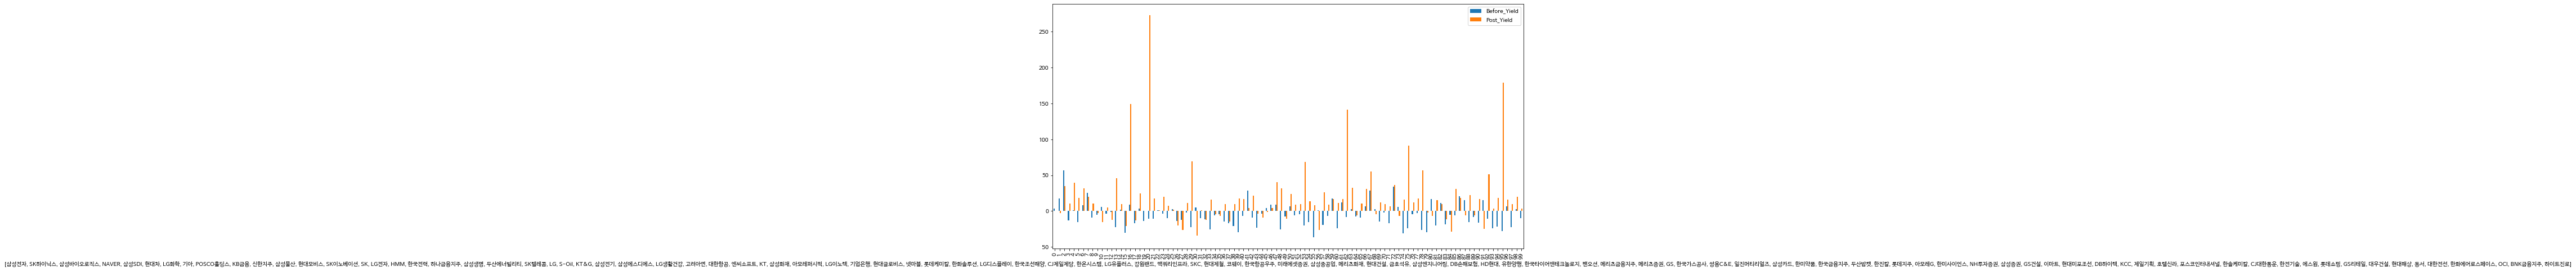

In [ ]:
result1 = backTesting(kospi100)
result1

In [ ]:
result1[['Company','Post_Yield']]

,Company,Post_Yield
0,삼성전자,0.463100
1,SK하이닉스,-2.541290
2,삼성바이오로직스,34.463867
3,NAVER,10.462750
4,삼성SDI,39.185071
...,...,...
95,대한전선,178.750000
96,한화에어로스페이스,16.108540
97,OCI,9.717734
98,BNK금융지주,19.706224
